In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings(action='ignore')
plt.style.use('fivethirtyeight')
import featuretools as ft
import dask.dataframe as dd
import gc
gc.enable()

#### Importing the dataset

###### Using dask



With Dask and its dataframe construct, you set up the dataframe must like you would in pandas but rather than loading the data into pandas, this approach keeps the dataframe as a sort of ‘pointer’ to the data file and doesn’t load anything until you specifically tell it to do so.

Source: http://pythondata.com/dask-large-csv-python/


In [2]:
%time

train_d=dd.read_csv('/home/shahul/my Datasets/kaggle/all(4) (1)/train.csv',blocksize=25e6)



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.3 µs


###### Using pandas

In [74]:
train=pd.read_csv('/home/shahul/my Datasets/kaggle/all(4) (1)/train.csv',nrows=50000)
test=pd.read_csv("/home/shahul/my Datasets/kaggle/all(4) (1)/test.csv",nrows=20000)


In [75]:
test_id=test['Id']

#### Basic description of the data

In [76]:
print('size of the training data',train.shape)

size of the training data (50000, 26)


There are 26 columns in our training data.

In [77]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [78]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,...,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,...,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217


In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
Id                 50000 non-null int64
groupId            50000 non-null int64
matchId            50000 non-null int64
assists            50000 non-null int64
boosts             50000 non-null int64
damageDealt        50000 non-null float64
DBNOs              50000 non-null int64
headshotKills      50000 non-null int64
heals              50000 non-null int64
killPlace          50000 non-null int64
killPoints         50000 non-null int64
kills              50000 non-null int64
killStreaks        50000 non-null int64
longestKill        50000 non-null float64
maxPlace           50000 non-null int64
numGroups          50000 non-null int64
revives            50000 non-null int64
rideDistance       50000 non-null float64
roadKills          50000 non-null int64
swimDistance       50000 non-null float64
teamKills          50000 non-null int64
vehicleDestroys    50000 non-null int64
wal

##### Missing values

In [80]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
maxPlace           0
numGroups          0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

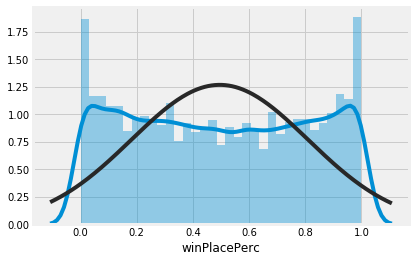

In [81]:
plt.figure()
sns.distplot(train['winPlacePerc'],fit=norm)
plt.show()

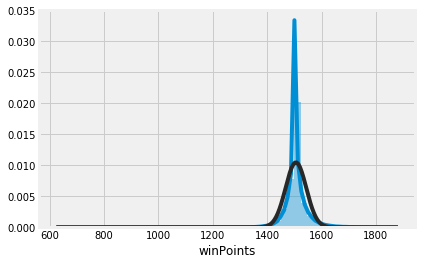

In [82]:
plt.figure()
sns.distplot(train['winPoints'],fit=norm)
plt.show()

In [83]:
train_group=train.groupby('groupId',as_index=False)['winPlacePerc'].agg('mean')

In [84]:
train_group.head()

,groupId,winPlacePerc
0,2,0.6786
1,24,0.8571
2,38,0.4138
3,86,0.2979
4,120,0.1600


In [85]:
train[train['groupId']==2]['winPlacePerc']

47734    0.6786
Name: winPlacePerc, dtype: float64

- From this it is clear that **winPlacePer** which is our target variable is same in each group

In [86]:
train_corr=train.drop(columns=['Id',"matchId","groupId"])


###### Are they correlated ?

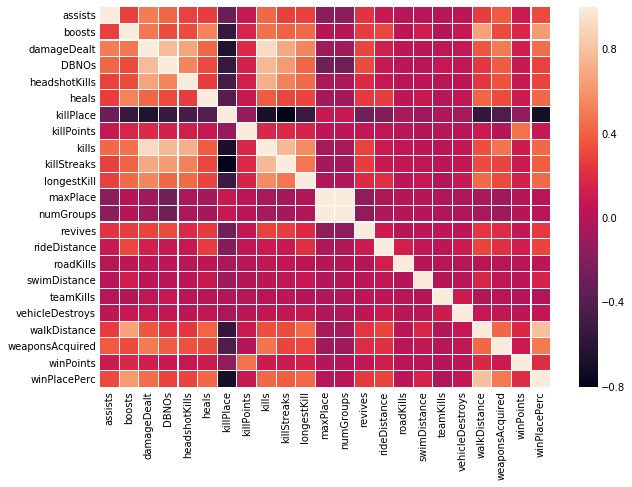

<Figure size 432x288 with 0 Axes>

In [87]:
plt.figure(figsize=(9,7))

sns.heatmap(train_corr.corr(),linewidths=.1)
plt.show()
plt.savefig('corr')

###### Why killplace always shows a negative correlation ?

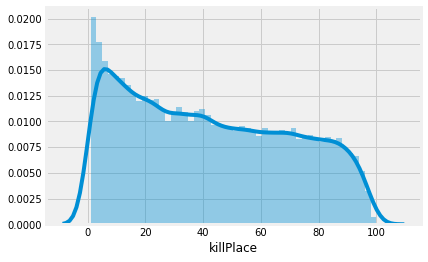

In [88]:
plt.figure()
sns.distplot(train['killPlace'],bins=50)
plt.show()

The **Killplace** feature shows negative correlation between other features because      
killplace is the Ranking in match of number of enemy players killed.

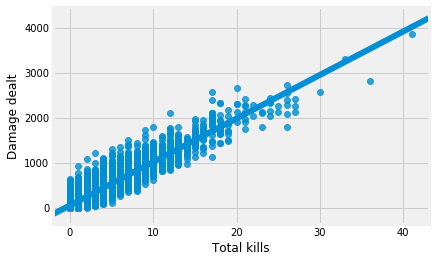

In [89]:
plt.figure()
sns.regplot(train['kills'].values,train['damageDealt'].values)
plt.gca().set_ylabel('Damage dealt')
plt.gca().set_xlabel('Total kills')
plt.show()


## Identifying cheaters

- ######  Types of cheaters

<img src="https://cdn.mos.cms.futurecdn.net/36pdCgyXDgKmbqSpxnJ6Ue-650-80.png">

When it comes to PUBG cheats there are two types of hacks that are pretty common, aim hacks and speed hacks. Both are pretty self explanatory, one makes you speed round the map at a rapid pace, while the other will automatically make sure that your bullets always head towards an opponent. Then there are a number of more subtle cheats that aren’t usually as obvious.

###### PUBG aimbots and hacks

<img src="https://cdn.mos.cms.futurecdn.net/pWwhZzoz8VSA3aYcnapvUo-650-80.jpg">

PUBG aimbots and hacks are probably the most annoying things out there. They will take control of a players aim and automatically target it towards opponents. This can be abused in multiple ways. The most obvious is that every bullet they fire that has a line of sight towards another player will hit, and is the explanation to why other players seem to be able to hit ridiculous cross map shots. 

In [90]:
print("Avergae no of enemy players knocked per game is",train['DBNOs'].sum()/len(train))

Avergae no of enemy players knocked per game is 0.92172


In [91]:
train_dbno=pd.DataFrame(train['DBNOs'].value_counts(),columns=['DBNOs'])
dbno=train_dbno.iloc[:9,:]
dbno.iloc[8]['DBNOs']=train_dbno.iloc[8:,:].sum()['DBNOs']


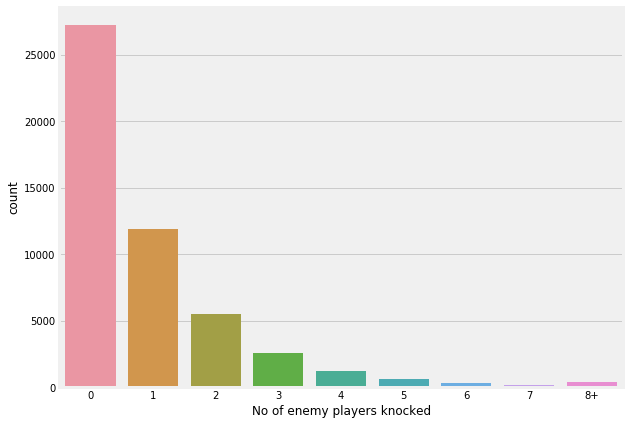

In [92]:
plt.figure(figsize=(9,7))
sns.barplot(dbno.index,dbno.DBNOs)
plt.gca().set_xticklabels([0,1,2,3,4,5,6,7,'8+'])
plt.gca().set_xlabel('No of enemy players knocked')
plt.gca().set_ylabel("count")
plt.show()

In [93]:
print("World record for the most number of DBNOs in a single game is",train_dbno.shape[0])

World record for the most number of DBNOs in a single game is 29


In [94]:
print("A player uses on an avergae {} boost items".format(train['boosts'].sum()/len(train)))

A player uses on an avergae 1.11444 boost items


In [95]:
print("A average player kills {} players".format(train['kills'].sum()/len(train)))

A average player kills 1.28534 players


In [96]:
print('A player uses on an average {}  heals'.format(train['heals'].sum()/len(train)))

A player uses on an average 1.34984  heals


In [97]:
print('A player uses on an average rides {} '.format(train['rideDistance'].sum()/len(train)))

A player uses on an average rides 474.21235990799994 


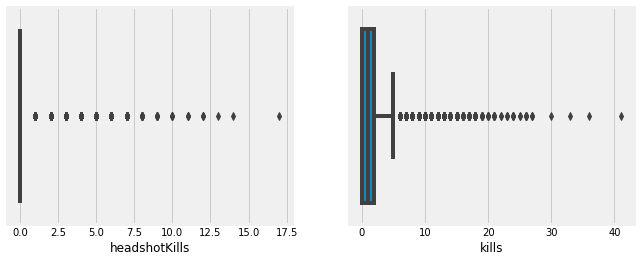

In [98]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_figwidth(10)
sns.boxplot(train['headshotKills'],ax=ax1)
sns.boxplot(train['kills'],ax=ax2)
plt.show()

In [99]:
set1=set(i for i in train[(train['kills']>40) & (train['heals']==0)].index.tolist())


- They might have high headshot rate with aimhacks

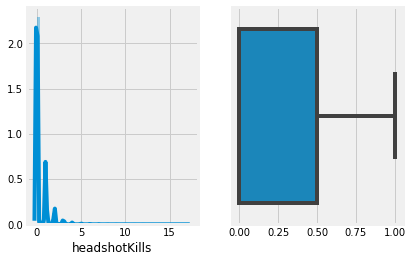

In [100]:
fig,(ax1,ax2)=plt.subplots(1,2)
sns.distplot(train['headshotKills'],ax=ax1)
sns.boxplot(train['headshotKills']/train['kills'],ax=ax2)

- Less movement

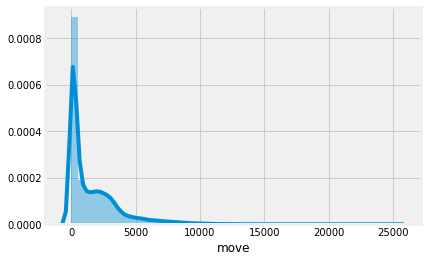

In [101]:
train['move']=train['rideDistance']+train['swimDistance']+train['walkDistance']
test['move']=test['rideDistance']+test['swimDistance']+test['walkDistance']
sns.distplot(train['move'])

In [102]:
set2=set(i for i in train[(train['move']==0) & (train['kills']>20) ].index.tolist())

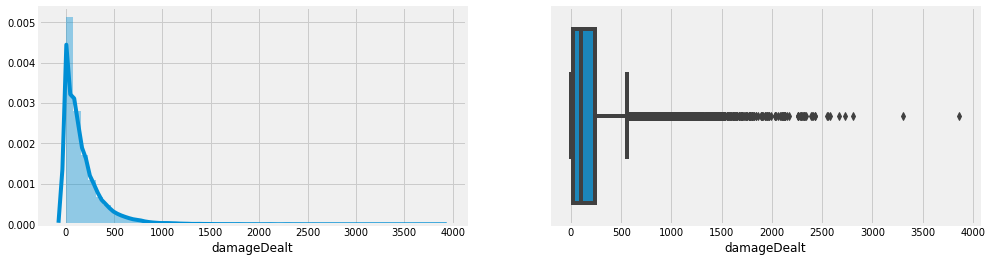

In [103]:

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_figwidth(15)

sns.distplot(train['damageDealt'],ax=ax1)
sns.boxplot(train['damageDealt'],ax=ax2)
plt.show()

There are outliers in damageDealt.

In [104]:
set3=set(i for i in train[(train['damageDealt']>4000) & (train['heals']<2)].index.tolist())

- ######  PUBG speed Hacks

<img src='https://cdn.mos.cms.futurecdn.net/Vd89dcrLiXGQq4ocje2bTR-650-80.jpg'>

- High ride distance

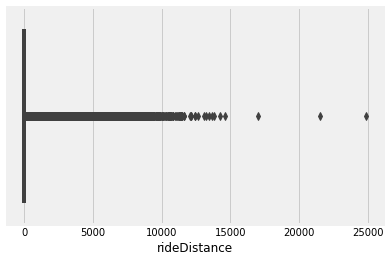

In [105]:
plt.figure()
sns.boxplot(train['rideDistance'])
plt.show()

- High roadkill rate

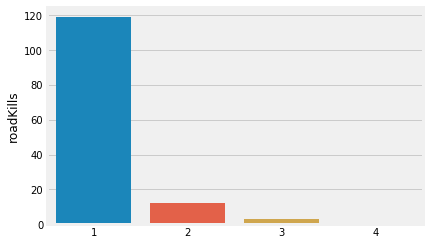

In [106]:
roadkills=train['roadKills'].value_counts()[1:]
sns.barplot(x=roadkills.index,y=roadkills)

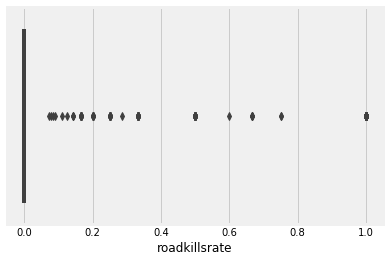

In [107]:
train['roadkillsrate']=(train['roadKills']/train['kills']).fillna(0)
sns.boxplot(train['roadkillsrate'])

plt.show()

In [108]:
set4=set(i for i in train[(train['rideDistance']>25000) & (train['roadkillsrate']>.4) ].index.tolist())

- ###### Recoil Scripts 

<img src='https://cdn.mos.cms.futurecdn.net/LodXF3A7ZFaHt8qNyevcZc-650-80.jpg'>

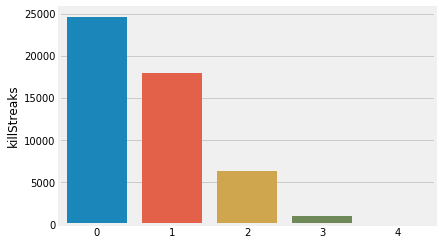

In [109]:
killstreak=pd.DataFrame(train['killStreaks'].value_counts())
killstreak.iloc[4]=killstreak.iloc[4:].sum()
killstreak=killstreak[:5]
sns.barplot(killstreak.index,killstreak['killStreaks'])

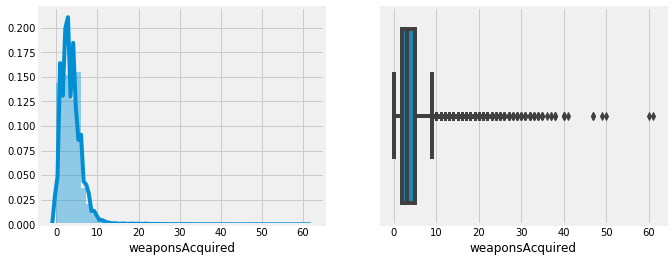

In [110]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_figwidth(10)
sns.distplot(train['weaponsAcquired'],ax=ax1)
sns.boxplot(train['weaponsAcquired'],ax=ax2)

In [111]:
set5=set(i for i in train[(train['killStreaks']>3) & (train['weaponsAcquired']> 30)].index.tolist())

In [112]:
set6=set(i for i in train[(train['killStreaks']>3) & (train['weaponsAcquired']> 30)].index.tolist())

In [113]:
sets=set1 | set2 | set3 | set4 | set5 | set6

In [114]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc', 'move', 'roadkillsrate'],
      dtype='object')

In [115]:
train.drop(train.index[list(sets)],inplace=True)

#### Feature engineering 

In [116]:
train.drop(['roadkillsrate'],axis=1,inplace=True)

In [117]:
train.columns.drop('winPlacePerc')==test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [118]:
def feature_engineering(is_train=True):
    if is_train: 
        print("processing train.csv")
        df = train
    else:
        print("processing test.csv")
        df = test
    
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    y = None
    if is_train: 
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: df_out = agg.reset_index()[['matchId','groupId']]
    else: df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)
    

    X = np.array(df_out, dtype=np.float64)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y
    
x_train, y = feature_engineering(True)



processing train.csv
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [119]:
test,z=feature_engineering(False)

processing test.csv
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [120]:
x_train.shape

(48354, 163)

In [121]:
test.shape

(20000, 163)

###### MinMax scaling

In [122]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1),copy=False).fit(x_train)
X_train=scaler.transform(x_train)


In [123]:
x_test=scaler.transform(test)

In [124]:

from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso,Ridge
from sklearn import preprocessing
from  sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [54]:
n_folds=2

def mbs(model):
    kf=KFold(n_folds,shuffle=True,random_state=42).get_n_splits(x_train)
    score=-cross_val_score(model,X_train,y,scoring='neg_mean_absolute_error',cv=kf)
    return score
   



In [59]:
lasso=Lasso(alpha=.003,random_state=1)

In [60]:
mbs(lasso)

array([0.10547651, 0.10732838])

In [68]:
ridge=Ridge(alpha=0.03,random_state=1)
mbs(ridge)

array([0.12276751, 0.09368647])

In [63]:
lasso.fit(X_train,y)
lasso.predict(x_test)

array([0.33690354, 0.6325428 , 0.20937539, ..., 0.76402945, 0.41414421,
       0.49821452])

In [66]:
lasso.score

<bound method RegressorMixin.score of Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)>

###### XGBoost

In [77]:
params={'learning_rate':[.02,.05,.1],'min_child_weight':[4],'max_depth':[8,10,15],"subsample":[.6,.4],"n_estimators":[300,500]}


In [ ]:
xgb_grid=GridSearchCV(xgb,param_grid=params,cv=2,verbose=True,n_jobs=-1,scoring='neg_mean_absolute_error')
xgb_grid.fit(x_train,y)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [212]:

xgb_grid.best_params_

In [125]:
xgb=XGBRegressor(learning_rate=.03,min_child_weight=4,max_depth=10,subsample=.4,n_estimators=300,n_jobs=-1)
mbs(xgb)

array([0.07200658, 0.07114707])

###### RandomForestRegressor

In [126]:
rf=RandomForestRegressor(n_estimators=400,criterion='mae',max_features='auto',max_depth=10,min_samples_split=6,min_samples_leaf=4,n_jobs=-1)
mbs(rf)

KeyboardInterrupt: 

In [71]:
RandomForestRegressor?

In [69]:
xgb.fit(X_train,y)
y_test=xgb.predict(x_test)


In [70]:
y_test

array([0.46246406, 0.5742213 , 0.25783998, ..., 0.77119875, 0.48432767,
       0.63544476], dtype=float32)

###### Making my submission

In [235]:
df=pd.DataFrame({'id':test_id,'winPlacePerc':y_test},columns=['id','winPlacePerc'])
csv=df[['id','winPlacePer']].to_csv('/home/shahul/my Datasets/kaggle/ghosts/submission.csv',index=False)

KeyError: "['winPlacePer'] not in index"

In [231]:
y=y*2-1

In [228]:
train[['groupId','winPlacePerc']].groupby('groupId').agg('mean')

,winPlacePerc
groupId,
2,0.6786
24,0.8571
38,0.4138
86,0.2979
120,0.1600
157,0.7857
171,0.3448
203,0.1923
298,0.1340
